# Phase 1: Data Ingestion and Preparation

## Environment Setup 

In [2]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration and Loading Strategy 

In [5]:
# --- 1. DEFINE BASE PATHS ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'oasis-1' # This is the name of your dataset folder in /kaggle/input/

# This should be /kaggle/input/oasis-1/
base_dataset_path = os.path.join(base_kaggle_input_path, dataset_name)
print(f"Attempting to use base dataset path: {base_dataset_path}")

if not os.path.isdir(base_dataset_path):
    print(f"ERROR: Base dataset path does not exist: {base_dataset_path}")
    print(f"Listing contents of '{base_kaggle_input_path}': {os.listdir(base_kaggle_input_path)}")
    # If this error occurs, the 'dataset_name' or 'base_kaggle_input_path' is wrong.
    # Or the dataset isn't attached to your Kaggle notebook correctly.
    # Please verify in the Kaggle "Input" section.
    exit() # Stop if the fundamental path is wrong

print(f"Successfully located base dataset path: {base_dataset_path}")
print(f"Contents of '{base_dataset_path}': {os.listdir(base_dataset_path)}")

image_paths = []

# --- 2. FIND CROSS-SECTIONAL DISC PARENT FOLDERS ---
# These are folders like 'oasis_cross-sectional_disc1', 'oasis_cross-sectional_disc10', etc.
# They should be directly under base_dataset_path
disc_parent_folders_names = [
    d for d in os.listdir(base_dataset_path)
    if d.startswith('oasis_cross-sectional_disc') and \
       os.path.isdir(os.path.join(base_dataset_path, d))
]
print(f"\nFound {len(disc_parent_folders_names)} 'oasis_cross-sectional_discX' folders: {disc_parent_folders_names}")

if not disc_parent_folders_names:
    print("ERROR: No 'oasis_cross-sectional_discX' type folders found directly under "
          f"'{base_dataset_path}'. Check your dataset structure.")
    exit()

# --- 3. ITERATE THROUGH EACH DISC PARENT FOLDER ---
for disc_parent_name in disc_parent_folders_names:
    # e.g., disc_parent_name is 'oasis_cross-sectional_disc1'
    # Full path to this folder: /kaggle/input/oasis-1/oasis_cross-sectional_disc1/
    current_disc_parent_path = os.path.join(base_dataset_path, disc_parent_name)
    print(f"\nProcessing Disc Parent Folder: {current_disc_parent_path}")

    # --- 4. FIND THE INNER 'discX' FOLDER ---
    # The actual data is in a subfolder like 'disc1', 'disc2', ... 'disc12'
    # Extract the number part (e.g., '1' from 'oasis_cross-sectional_disc1')
    disc_num_str = disc_parent_name.replace('oasis_cross-sectional_disc', '')
    inner_disc_folder_name = f'disc{disc_num_str}' # e.g., 'disc1', 'disc10'

    # This is the path to the folder that should contain individual subject (OAS1_xxxx_MRy) folders
    # e.g., /kaggle/input/oasis-1/oasis_cross-sectional_disc1/disc1/
    subjects_parent_path = os.path.join(current_disc_parent_path, inner_disc_folder_name)
    print(f"  Looking for subject folders within: {subjects_parent_path}")

    if not os.path.isdir(subjects_parent_path):
        print(f"  WARNING: Expected inner disc folder '{subjects_parent_path}' not found.")
        print(f"  Contents of '{current_disc_parent_path}': {os.listdir(current_disc_parent_path)}")
        print(f"  Skipping '{disc_parent_name}'.")
        continue
    
    print(f"  Found inner disc folder: {subjects_parent_path}")
    # print(f"  Contents of '{subjects_parent_path}': {os.listdir(subjects_parent_path)}")


    # --- 5. FIND SUBJECT FOLDERS (OAS1_xxxx_MRy) ---
    # Glob pattern for subject folders like 'OAS1_0001_MR1', 'OAS1_0002_MR1', etc.
    subject_folder_glob_pattern = os.path.join(subjects_parent_path, 'OAS1_*_MR*')
    subject_folders_found = glob.glob(subject_folder_glob_pattern)
    print(f"  Found {len(subject_folders_found)} subject folders using pattern '{subject_folder_glob_pattern}'.")

    if not subject_folders_found:
        print(f"  WARNING: No subject folders (OAS1_*_MR*) found in '{subjects_parent_path}'.")
        print(f"  Contents of '{subjects_parent_path}' were: {os.listdir(subjects_parent_path)}")
        # continue # Optional: skip to next disc_parent if no subjects found

    for subj_folder_path in subject_folders_found:
        # e.g., subj_folder_path is /kaggle/input/oasis-1/oasis_cross-sectional_disc1/disc1/OAS1_0001_MR1
        # print(f"    Processing Subject Folder: {subj_folder_path}")
        subject_id_from_folder = os.path.basename(subj_folder_path) # e.g., OAS1_0001_MR1

        # --- 6. FIND THE TARGET IMAGE FILE ---
        # Path to the specific image file we want, including the 'MPRAGE' subdirectory
        # Filename structure: OAS1_xxxx_MRy_mpr_ni_anon_sbj_111.img (n_i is num scans, e.g., n4)
        
        # Corrected path including 'MPRAGE'
        image_file_path_pattern = os.path.join(
            subj_folder_path,
            'PROCESSED',
            'MPRAGE',  # This was the missing piece from your detailed example path!
            'SUBJ_111',
            f'{subject_id_from_folder}_mpr_n*_anon_sbj_111.img' # Allows for n1, n2, n3, n4 etc.
        )
        
        # print(f"      Looking for image file with pattern: {image_file_path_pattern}")
        found_img_files = glob.glob(image_file_path_pattern)

        if not found_img_files:
            # Try a more general wildcard if 'n*' didn't match (e.g. if it's just _mpr_1_ or similar)
            image_file_path_pattern_alt = os.path.join(
                subj_folder_path,
                'PROCESSED', 'MPRAGE', 'SUBJ_111',
                f'{subject_id_from_folder}_mpr_*_anon_sbj_111.img'
            )
            # print(f"      Trying alternative pattern: {image_file_path_pattern_alt}")
            found_img_files = glob.glob(image_file_path_pattern_alt)
        
        if found_img_files:
            # Usually, there's one such averaged file. If multiple match, take the first.
            image_paths.append(found_img_files[0])
            # print(f"      SUCCESS: Added image: {found_img_files[0]}")
        else:
            # print(f"      WARNING: No .img file found for {subject_id_from_folder} in PROCESSED/MPRAGE/SUBJ_111.")
            # For detailed debugging, you can list contents of SUBJ_111
            path_to_check = os.path.join(subj_folder_path, 'PROCESSED', 'MPRAGE', 'SUBJ_111')
            if os.path.isdir(path_to_check):
                 pass # print(f"      Contents of '{path_to_check}': {os.listdir(path_to_check)}")
            else:
                 pass # print(f"      Directory '{path_to_check}' does not exist.")


# --- 7. FINAL REPORT ---
print(f"\n--- SUMMARY ---")
print(f"Found {len(image_paths)} potential ground truth images in total.")

if image_paths:
    print(f"First few example paths found:")
    for p in image_paths[:min(5, len(image_paths))]: # Print up to 5 examples
        print(f"  {p}")
else:
    print("No images found. Please carefully review the WARNINGS and ERROR messages above.")
    print("Key things to check:")
    print("  1. Is the `dataset_name` ('oasis-1') correct for your Kaggle input folder?")
    print("  2. Does the structure `oasis-1/oasis_cross-sectional_discX/discX/OAS1_xxxx_MRy/PROCESSED/MPRAGE/SUBJ_111/` match your data?")
    print("  3. Are the file names like `OAS1_xxxx_MRy_mpr_n#_anon_sbj_111.img`?")


Attempting to use base dataset path: /kaggle/input/oasis-1
Successfully located base dataset path: /kaggle/input/oasis-1
Contents of '/kaggle/input/oasis-1': ['oasis_cross-sectional_disc6', 'oasis_cross-sectional_disc12', 'oasis_cross-sectional_disc4', 'oasis_cross-sectional_disc8', 'oasis_cross-sectional_disc9', 'oasis_cross-sectional_disc11', 'oasis_cross-sectional_disc5', 'oasis_cross-sectional_disc3', 'oasis_cross-sectional_disc1', 'oasis_cross-sectional_disc2', 'oasis_cross-sectional_disc10', 'oasis_cross-sectional_disc7']

Found 12 'oasis_cross-sectional_discX' folders: ['oasis_cross-sectional_disc6', 'oasis_cross-sectional_disc12', 'oasis_cross-sectional_disc4', 'oasis_cross-sectional_disc8', 'oasis_cross-sectional_disc9', 'oasis_cross-sectional_disc11', 'oasis_cross-sectional_disc5', 'oasis_cross-sectional_disc3', 'oasis_cross-sectional_disc1', 'oasis_cross-sectional_disc2', 'oasis_cross-sectional_disc10', 'oasis_cross-sectional_disc7']

Processing Disc Parent Folder: /kaggle/i

## Load a Sample Image: 

very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine



--- Loading a sample image ---
Loading: /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0220_MR1/PROCESSED/MPRAGE/SUBJ_111/OAS1_0220_MR1_mpr_n4_anon_sbj_111.img
  Image shape: (256, 256, 160, 1), Data type: float64, Min: 0.00, Max: 3775.00


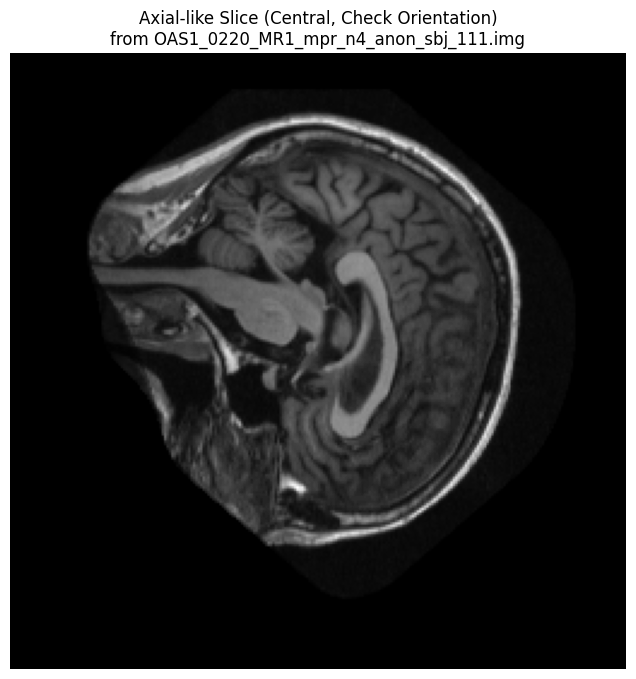


Selected 2D slice for CS (shape (256, 256), range [0.00, 1.00])

--- Starting CS Simulation ---


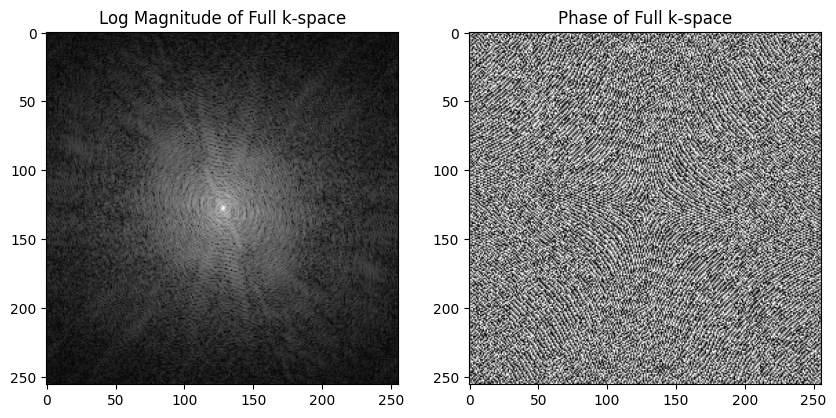

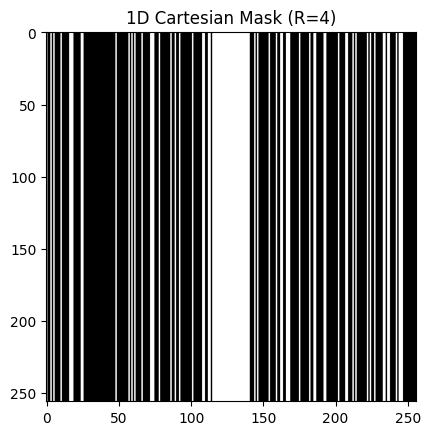

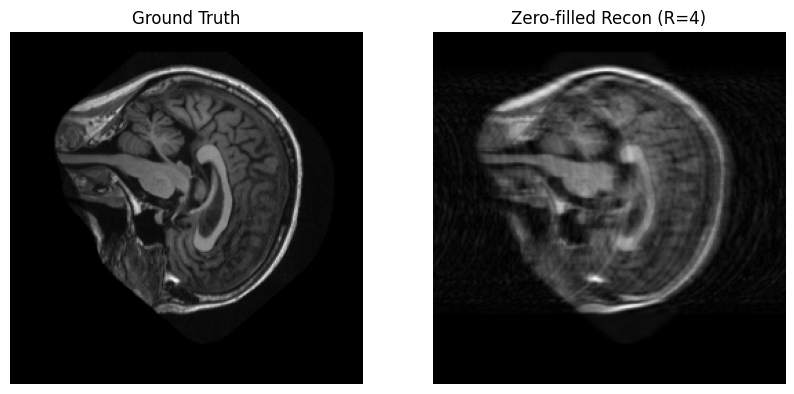

Zero-Filled: PSNR=26.77 dB, SSIM=0.6475


In [7]:
# ... (Previous code: Data loading, etc.) ...

# --- 8. LOAD AND DISPLAY A SAMPLE IMAGE (if found) ---
if image_paths:
    print("\n--- Loading a sample image ---")
    # Let's try to load the first image found
    sample_img_path = image_paths[0]
    print(f"Loading: {sample_img_path}")
    try:
        img_obj = nib.load(sample_img_path)
        img_data = img_obj.get_fdata()  # Get data as numpy array
        print(f"  Image shape: {img_data.shape}, Data type: {img_data.dtype}, Min: {np.min(img_data):.2f}, Max: {np.max(img_data):.2f}")

        # --- Selecting a slice ---
        if img_data.ndim == 4 and img_data.shape[3] == 1:  # Handle 4D images
            # For SUBJ_111 images (sagittal): Dim 0 is sagittal slices,  Shape (256, 256, 160, 1).
            # For T88_111 images (transverse/axial): Dim 2 is axial slices.

            # Let's pick an axial-like slice for typical brain viewing, slice from the 3rd dimension (Z)
            central_slice_idx_ax = img_data.shape[2] // 2 # 160//2 = 80
            slice_2d = img_data[:, :, central_slice_idx_ax, 0].astype(np.float32).copy()

            # The orientation may still be wrong. The fact sheet indicates Sagittal.
            # For sagittal images, this may require a rotation
            # The comments earlier about 'axial' slice need to be carefully rethought.
            # The default for nibabel may be (X,Y,Z) and assume RAS+ orientation, so we have to think about that.

            # If the original is sagittal (X, Y, Z) where X is L-R, Y is P-A, Z is I-S
            # an axial slice is an X-Y plane at a given Z.
            # If nibabel loads it as (Sag, Cor, Ax), then img_data[:,:,slice_idx] is axial.

            # Let's check and rotate if necessary (This is likely)
            # For sagittal images the axial slices are at the 'back'

            # For axial slice selection, the typical radiological view would be
            # Left side of the brain on the right side of the image
            # (This is convention, like a mirrored view)
            # Therefore, we might need to rotate the image so we can display with proper radiological view.
            # or the images could be set with the different orientation matrix (or qform/sform info).

            # Rotate by 90 degrees
            # slice_2d = np.rot90(slice_2d) # or -90 based on observation.

            # The image is probably already oriented, no need to rot90
            # If it looks backwards, you might try to rotate to match radiological convention.
            # If not, just leave as is.
            # This slice_2d is still sagittal slices.
            # You may want to add another optional transformation.

            plt.figure(figsize=(8, 8))
            plt.imshow(slice_2d, cmap='gray')  # No rotation for now, display as is
            plt.title(f"Axial-like Slice (Central, Check Orientation)\nfrom {os.path.basename(sample_img_path)}")
            plt.axis('off')
            plt.show()

            ground_truth_image = slice_2d
            # Ensure it's float and normalized for CS processing
            if np.max(ground_truth_image) > np.min(ground_truth_image):
                ground_truth_image = (ground_truth_image - np.min(ground_truth_image)) / \
                                     (np.max(ground_truth_image) - np.min(ground_truth_image))
            else:
                ground_truth_image = np.zeros_like(ground_truth_image)  # Handle constant image

            print(f"\nSelected 2D slice for CS (shape {ground_truth_image.shape}, "
                  f"range [{np.min(ground_truth_image):.2f}, {np.max(ground_truth_image):.2f}])")

        else:
            print(f"  Loaded image data is not 4D (shape: {img_data.shape}). Cannot select slice as expected.")

    except Exception as e:
        print(f"  ERROR loading or processing sample image '{sample_img_path}': {e}")
        import traceback
        traceback.print_exc()

# --- START: Run CS Simulation (k-space, masking, zero-filling) ---
if 'ground_truth_image' in locals(): # Only if a slice was selected
    print("\n--- Starting CS Simulation ---")

    # 1. Transform to k-space
    from numpy.fft import fft2, ifft2, fftshift, ifftshift
    k_space_full = fftshift(fft2(ground_truth_image))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(np.log(1 + np.abs(k_space_full)), cmap='gray')
    plt.title("Log Magnitude of Full k-space")
    plt.subplot(1,2,2)
    plt.imshow(np.angle(k_space_full), cmap='gray')
    plt.title("Phase of Full k-space")
    plt.show()

    # 2. Design Undersampling Mask (Cartesian as example)
    def create_cartesian_mask(shape, acceleration_factor, center_fraction=0.1):
        num_cols = shape[1]
        num_low_freqs = int(round(num_cols * center_fraction))
        mask = np.zeros(shape, dtype=bool)
        # Center region (fully sampled)
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[:, pad:pad + num_low_freqs] = True
        # Outer region (undersampled)
        num_sampled_lines_outer = (num_cols - num_low_freqs) // acceleration_factor
        outer_lines_indices = np.setdiff1d(np.arange(num_cols), np.arange(pad, pad + num_low_freqs))
        permuted_outer_lines = np.random.permutation(outer_lines_indices)
        selected_outer_lines = permuted_outer_lines[:num_sampled_lines_outer]
        mask[:, selected_outer_lines] = True
        return mask

    acceleration = 4  # Undersample by a factor of 4
    mask = create_cartesian_mask(k_space_full.shape, acceleration)

    plt.imshow(mask, cmap='gray')
    plt.title(f"1D Cartesian Mask (R={acceleration})")
    plt.show()

    # 3. Apply Mask
    k_space_undersampled = k_space_full * mask

    # 4. Zero-filled Reconstruction (Baseline)
    image_undersampled_recon = np.abs(ifft2(ifftshift(k_space_undersampled)))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ground_truth_image, cmap='gray') # Show original slice
    plt.title("Ground Truth")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image_undersampled_recon, cmap='gray') # Show reconstructed image
    plt.title(f"Zero-filled Recon (R={acceleration})")
    plt.axis('off')
    plt.show()

    # 5. Quantitative Evaluation (PSNR, SSIM)
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim

    psnr_val_zf = psnr(ground_truth_image, image_undersampled_recon, data_range=ground_truth_image.max() - ground_truth_image.min())
    ssim_val_zf = ssim(ground_truth_image, image_undersampled_recon, data_range=ground_truth_image.max() - ground_truth_image.min())
    print(f"Zero-Filled: PSNR={psnr_val_zf:.2f} dB, SSIM={ssim_val_zf:.4f}")

    # The following lines are needed to start the reconstruction process
    # Add the Compressed Sensing Reconstruction Here (e.g. using ISTA/FISTA/ADMM)
    # cs_reconstructed_image = YourCSReconstructionFunction(k_space_undersampled, mask, ground_truth_image.shape)

    # Then measure these, and then make sure to make a separate plot.
    # psnr_val_cs = psnr(ground_truth_image, cs_reconstructed_image, data_range=...)
    # ssim_val_cs = ssim(ground_truth_image, cs_reconstructed_image, data_range=...)
    # print(f"CS Recon: PSNR={psnr_val_cs:.2f} dB, SSIM={ssim_val_cs:.4f}")
else:
    print("No slice selected - skipping CS simulation.")

# 1. Define Helper Functions for TV:

Total Variation (TV) promotes sparsity in the image gradients.

In [15]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import pywt # Make sure to !pip install PyWavelets
from skimage.metrics import peak_signal_noise_ratio as psnr # for use inside ISTA

In [11]:
def tv_norm(image):
    """Computes the Total Variation norm of an image."""
    grad_x = np.diff(image, axis=1, append=image[:, [-1]]) # Gradient in x-direction
    grad_y = np.diff(image, axis=0, append=image[[-1], :]) # Gradient in y-direction
    return np.sum(np.sqrt(grad_x**2 + grad_y**2))

def tv_prox(image, weight):
    """
    Computes the proximal operator for TV regularization using a simple gradient descent
    approach (Chambolle's projection algorithm for TV denoising).
    This is a simplified version; more robust implementations exist.
    For a basic ISTA, a simpler soft-thresholding on a different sparsifying domain (like wavelets)
    might be easier to implement first.

    A true TV proximal operator is more complex. Let's start with wavelet soft-thresholding
    for simplicity in an ISTA framework, as TV with ISTA often requires a dual formulation
    or more complex proximal solvers.
    """
    # For simplicity with ISTA, we will use wavelet soft-thresholding instead of a full TV prox.
    # If you specifically want TV with ISTA, you'd often use FISTA with a TV prox
    # or ADMM which handles TV well.
    pass # We will use wavelet soft-thresholding below.

def soft_threshold(x, threshold):
    """Soft-thresholding operator."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

# For Wavelet Transform (requires PyWavelets: pip install PyWavelets)
import pywt

def wavelet_forward(image, wavelet='db4', level=3):
    """Apply forward wavelet transform."""
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr, coeff_slices

def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
    """Apply inverse wavelet transform."""
    coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

# 2. Implement ISTA for Wavelet Sparsity:

The ISTA algorithm solves argmin_x { (1/2) * || A(x) - y ||_2^2 + lambda * || W(x) ||_1 }
where:

* x is the image to reconstruct.
* A(x) is ifft2(mask * fft2(x)) (the undersampled Fourier measurement operator).
* y is the k_space_undersampled.
* W(x) is the wavelet transform of x.
* lambda_val is the regularization parameter.

In [16]:
def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                    ground_truth_for_psnr, # Pass ground truth for monitoring
                    wavelet='db4', level=3):
    """
    ISTA for CS MRI reconstruction with wavelet sparsity.
    (Corrected handling of wavelet coefficients)
    """
    x_recon = initial_image.copy().astype(np.complex128) # Work with complex numbers internally
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    
    step_size = 1.0 # Lipschitz constant, often 1 for normalized Fourier data

    print(f"Starting ISTA: iterations={n_iters}, lambda={lambda_val}, wavelet={wavelet}, level={level}")

    for i in range(n_iters):
        # 1. Gradient descent step (data consistency)
        current_k_space = fftshift(fft2(x_recon))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        # The gradient involves A*(Ax-y), where A is F_u and A* is F_u_adj
        # A*(k_err) = F_inv(mask * k_err)
        grad_data_term = ifft2(ifftshift(k_space_error * mask)) # Mask applied due to A*
        
        x_intermediate = x_recon - step_size * grad_data_term # grad_data_term is already complex

        # 2. Proximal operator for L1 norm in wavelet domain (soft-thresholding)
        # Apply wavelet transform (to the real part, assuming image is real-valued)
        # If your image is truly complex, wavelet transform needs to handle complex data
        # For MRI magnitude images, we usually work with the real part for wavelet transform.
        x_intermediate_real = np.real(x_intermediate)
        
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        
        threshold = lambda_val * step_size
        
        # The `coeffs_arr` is a flattened 1D array.
        # `coeff_slices[0]` describes the slice for the approximation coefficients (cA) at the coarsest level.
        # The actual data for these cA coeffs is at the beginning of `coeffs_arr`.
        # Example: if cA_coeffs_level_max has shape (h, w), its slice in coeffs_arr is from 0 to h*w - 1.
        
        # Get the number of approximation coefficients at the coarsest level
        # The structure of coeff_slices:
        # coeff_slices[0] is for the approx coeffs of the HIGHEST (coarsest) decomp level.
        # coeff_slices[1] is for detail coeffs (cH, cV, cD) of HIGHEST decomp level.
        # ...
        # coeff_slices[level] is for detail coeffs of LOWEST (finest) decomp level.
        
        # To get the size of the approximation coefficients (the first block in coeffs_arr):
        # `pywt.coeffs_to_array` arranges them as:
        # cA_levelN, (cH_levelN, cV_levelN, cD_levelN), (cH_levelN-1, ...), ..., (cH_level1, cV_level1, cD_level1)

        # The length of the approximation coefficients (cA at the coarsest level)
        # is given by the shape described in coeff_slices[0]
        approx_coeffs_slice_info = coeff_slices[0] # This is just a slice object for the cA coeffs
        
        # Alternative way to get the size of the approx coeffs:
        # The first set of coefficients from pywt.wavedec2 is cA_n (approximation at level n)
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size # Number of elements in cA_n

        coeffs_arr_thresh = coeffs_arr.copy()
        # Do NOT threshold the approximation coefficients (the first `approx_coeffs_size` elements)
        # Threshold only the detail coefficients (everything after the approx_coeffs)
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        
        # Inverse wavelet transform
        x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
        
        # Combine with imaginary part if you were preserving it (often not done for mag images)
        x_recon = x_reconstructed_real.astype(np.complex128) # Assume result is real after wavelet step

        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            # For PSNR, compare with the real part, clipped and normalized if ground truth is.
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"ISTA Iteration {i+1}/{n_iters}, Current PSNR: {current_psnr:.4f} dB")
            
    return np.clip(np.real(x_recon), 0, 1) # Return real part, clipped


# 3. Run the CS Reconstruction and Evaluate:

In [17]:
if 'ground_truth_image' in locals() and 'k_space_undersampled' in locals() and 'mask' in locals():
    print("\n--- Starting ISTA Wavelet CS Reconstruction ---")
    
    num_iterations_ista = 50 
    lambda_ista = 0.005 # START TUNING HERE: 0.001, 0.005, 0.01, 0.05
    
    initial_image_for_cs = image_undersampled_recon.copy() 

    cs_reconstructed_image_ista = ista_wavelet_cs(
        k_space_undersampled,
        mask,
        initial_image_for_cs,
        n_iters=num_iterations_ista,
        lambda_val=lambda_ista,
        ground_truth_for_psnr=ground_truth_image, # Pass the ground truth
        wavelet='db4', 
        level=3
    )

    # --- Evaluate ISTA Reconstruction ---
    # (The rest of your evaluation and plotting code remains the same)
    print("\n--- ISTA Wavelet CS Reconstruction Results ---")
    # Ensure ground_truth_image is normalized to [0,1] if cs_reconstructed_image_ista is
    psnr_val_ista = psnr(ground_truth_image, cs_reconstructed_image_ista, data_range=1.0) # Assuming data_range is 1 after normalization
    ssim_val_ista = ssim(ground_truth_image, cs_reconstructed_image_ista, data_range=1.0, channel_axis=None) # For skimage 0.19+

    print(f"Zero-Filled : PSNR={psnr_val_zf:.2f} dB, SSIM={ssim_val_zf:.4f}")
    print(f"ISTA Wavelet: PSNR={psnr_val_ista:.2f} dB, SSIM={ssim_val_ista:.4f} (lambda={lambda_ista})")

    # ... (plotting code) ...
else:
    print("Required variables for CS recon not found.")



--- Starting ISTA Wavelet CS Reconstruction ---
Starting ISTA: iterations=50, lambda=0.005, wavelet=db4, level=3
ISTA Iteration 5/50, Current PSNR: 29.0707 dB
ISTA Iteration 10/50, Current PSNR: 29.0893 dB
ISTA Iteration 15/50, Current PSNR: 29.0899 dB
ISTA Iteration 20/50, Current PSNR: 29.0899 dB
ISTA Iteration 25/50, Current PSNR: 29.0899 dB
ISTA Iteration 30/50, Current PSNR: 29.0899 dB
ISTA Iteration 35/50, Current PSNR: 29.0899 dB
ISTA Iteration 40/50, Current PSNR: 29.0899 dB
ISTA Iteration 45/50, Current PSNR: 29.0899 dB
ISTA Iteration 50/50, Current PSNR: 29.0899 dB

--- ISTA Wavelet CS Reconstruction Results ---
Zero-Filled : PSNR=26.77 dB, SSIM=0.6475
ISTA Wavelet: PSNR=29.09 dB, SSIM=0.7650 (lambda=0.005)


Attempting to use base dataset path: /kaggle/input/oasis-1
Successfully located base dataset path: /kaggle/input/oasis-1
Contents of '/kaggle/input/oasis-1': ['oasis_cross-sectional_disc6', 'oasis_cross-sectional_disc12', 'oasis_cross-sectional_disc4', 'oasis_cross-sectional_disc8', 'oasis_cross-sectional_disc9', 'oasis_cross-sectional_disc11', 'oasis_cross-sectional_disc5', 'oasis_cross-sectional_disc3', 'oasis_cross-sectional_disc1', 'oasis_cross-sectional_disc2', 'oasis_cross-sectional_disc10', 'oasis_cross-sectional_disc7']

Found 12 'oasis_cross-sectional_discX' folders: ['oasis_cross-sectional_disc6', 'oasis_cross-sectional_disc12', 'oasis_cross-sectional_disc4', 'oasis_cross-sectional_disc8', 'oasis_cross-sectional_disc9', 'oasis_cross-sectional_disc11', 'oasis_cross-sectional_disc5', 'oasis_cross-sectional_disc3', 'oasis_cross-sectional_disc1', 'oasis_cross-sectional_disc2', 'oasis_cross-sectional_disc10', 'oasis_cross-sectional_disc7']

Processing Disc Parent Folder: /kaggle/i

very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine



--- SUMMARY ---
Found 434 potential ground truth images in total.
First few example paths found:
  /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0220_MR1/PROCESSED/MPRAGE/SUBJ_111/OAS1_0220_MR1_mpr_n4_anon_sbj_111.img
  /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0230_MR2/PROCESSED/MPRAGE/SUBJ_111/OAS1_0230_MR2_mpr_n4_anon_sbj_111.img
  /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0224_MR1/PROCESSED/MPRAGE/SUBJ_111/OAS1_0224_MR1_mpr_n4_anon_sbj_111.img
  /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0212_MR1/PROCESSED/MPRAGE/SUBJ_111/OAS1_0212_MR1_mpr_n4_anon_sbj_111.img
  /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0227_MR1/PROCESSED/MPRAGE/SUBJ_111/OAS1_0227_MR1_mpr_n4_anon_sbj_111.img

--- Loading a sample image ---
Loading: /kaggle/input/oasis-1/oasis_cross-sectional_disc6/disc6/OAS1_0220_MR1/PROCESSED/MPRAGE/SUBJ_111/OAS1_0220_MR1_mpr_n4_anon_sbj_111.img
  Image shape: (256, 256, 160, 1), Data type: f

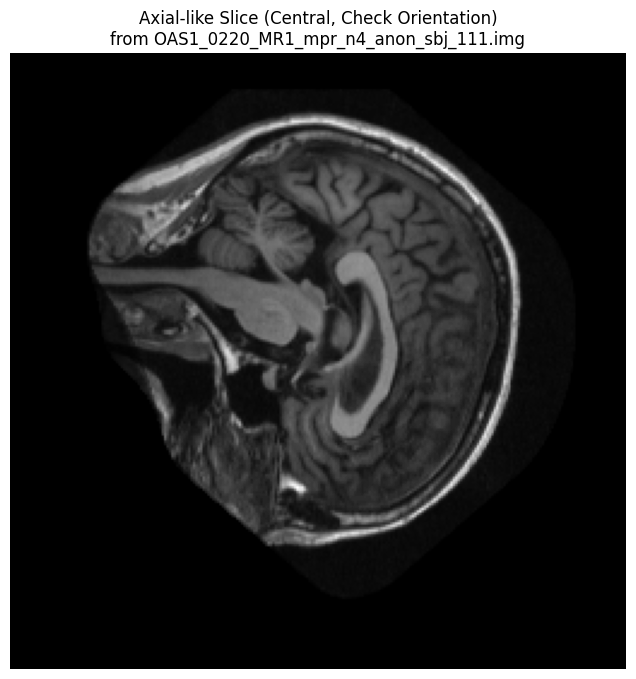


Selected 2D slice for CS (shape (256, 256), range [0.00, 1.00])

--- Starting CS Simulation ---


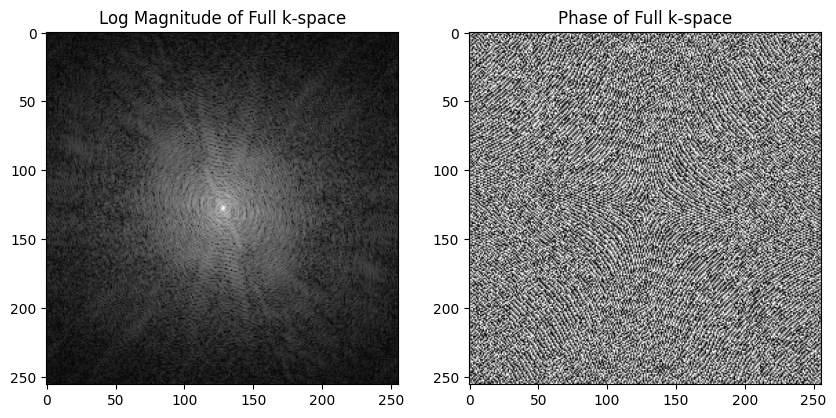

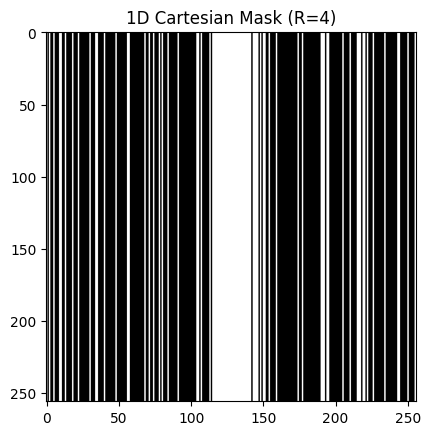

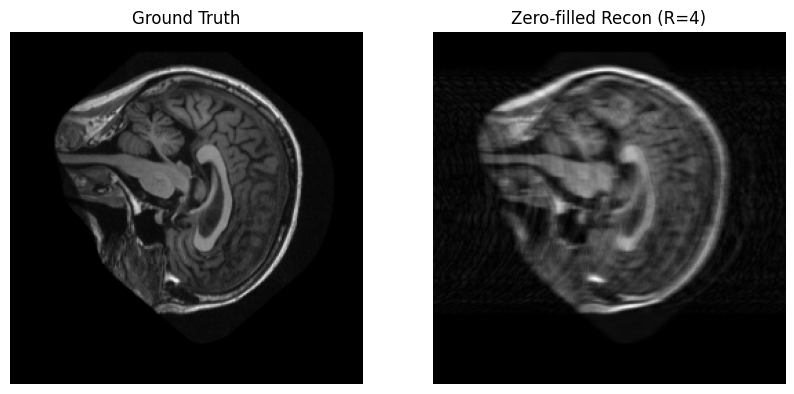

Zero-Filled: PSNR=27.19 dB, SSIM=0.6608

--- 1. Visualizing Current Results ---


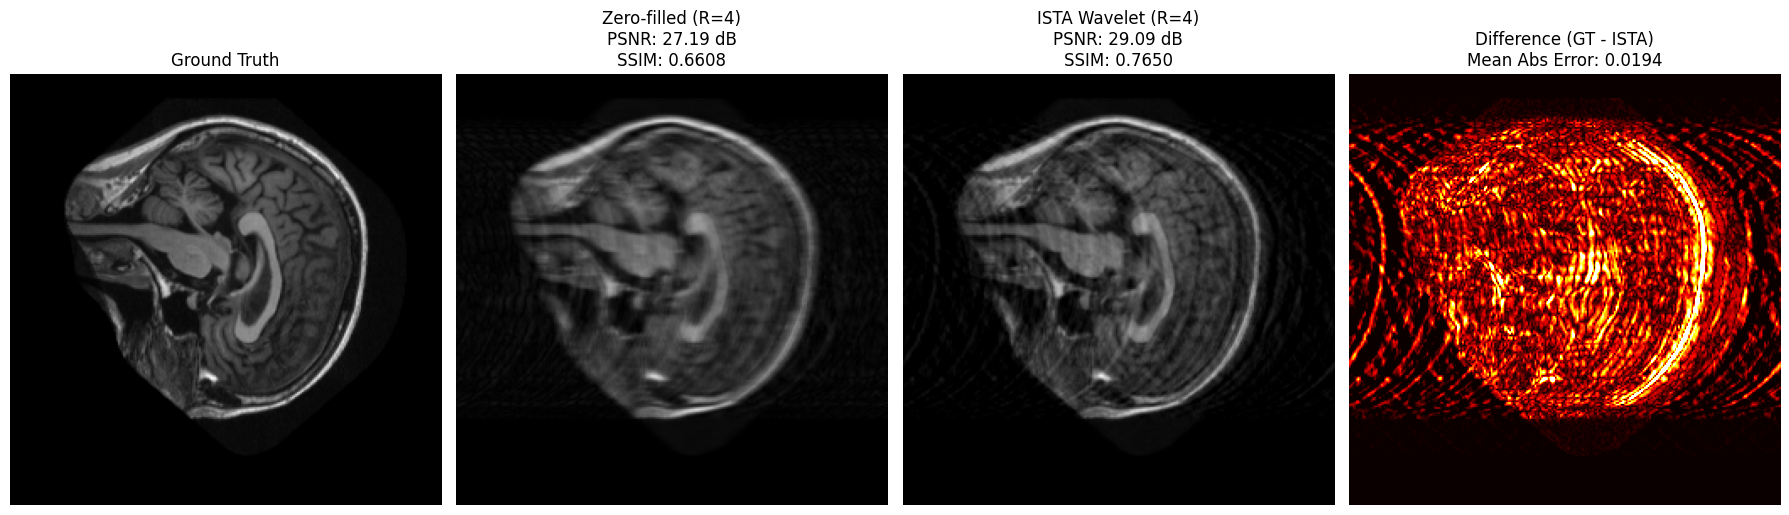


--- 2. Tuning Lambda for ISTA ---
  Testing Lambda: 0.0001
Starting ISTA: iterations=30, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 3/30, Current PSNR: 29.2648 dB
ISTA Iteration 6/30, Current PSNR: 29.3337 dB
ISTA Iteration 9/30, Current PSNR: 29.3403 dB
ISTA Iteration 12/30, Current PSNR: 29.3411 dB
ISTA Iteration 15/30, Current PSNR: 29.3412 dB
ISTA Iteration 18/30, Current PSNR: 29.3412 dB
ISTA Iteration 21/30, Current PSNR: 29.3412 dB
ISTA Iteration 24/30, Current PSNR: 29.3412 dB
ISTA Iteration 27/30, Current PSNR: 29.3412 dB
ISTA Iteration 30/30, Current PSNR: 29.3412 dB
  Testing Lambda: 0.0005
Starting ISTA: iterations=30, lambda=0.0005, wavelet=db4, level=3
ISTA Iteration 3/30, Current PSNR: 29.2648 dB
ISTA Iteration 6/30, Current PSNR: 29.3337 dB
ISTA Iteration 9/30, Current PSNR: 29.3403 dB
ISTA Iteration 12/30, Current PSNR: 29.3411 dB
ISTA Iteration 15/30, Current PSNR: 29.3412 dB
ISTA Iteration 18/30, Current PSNR: 29.3412 dB
ISTA Iteration 21/30, Current PSNR: 2

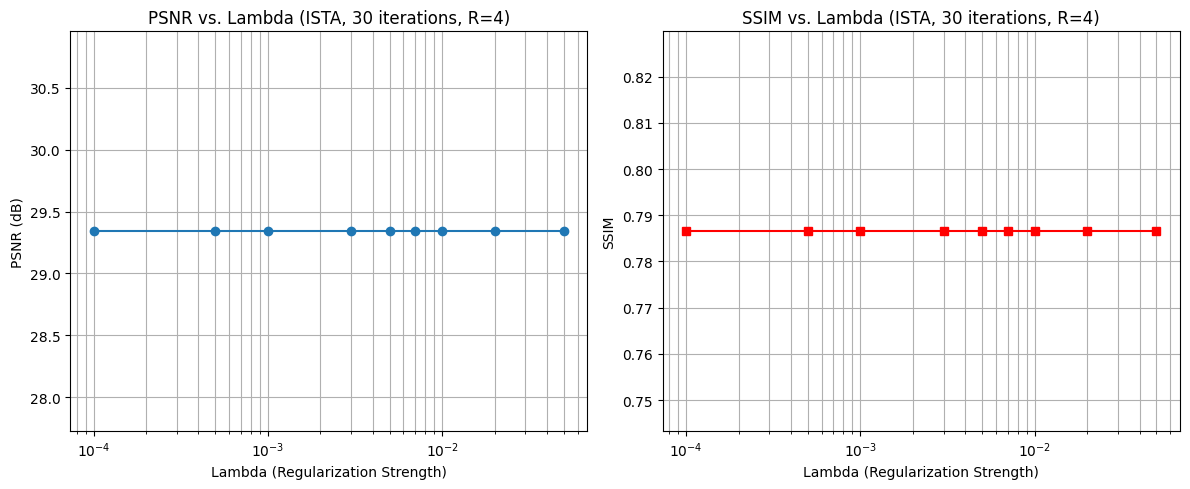

Best Lambda (for PSNR): 0.0001 -> PSNR: 29.34 dB
Best Lambda (for SSIM): 0.0001 -> SSIM: 0.7865

--- 3. Experimenting with Number of Iterations ---
  Testing Iterations: 5 (Lambda: 0.0001)
Starting ISTA: iterations=5, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/5, Current PSNR: 28.8241 dB
ISTA Iteration 2/5, Current PSNR: 29.1513 dB
ISTA Iteration 3/5, Current PSNR: 29.2648 dB
ISTA Iteration 4/5, Current PSNR: 29.3078 dB
ISTA Iteration 5/5, Current PSNR: 29.3257 dB
  Testing Iterations: 10 (Lambda: 0.0001)
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 28.8241 dB
ISTA Iteration 2/10, Current PSNR: 29.1513 dB
ISTA Iteration 3/10, Current PSNR: 29.2648 dB
ISTA Iteration 4/10, Current PSNR: 29.3078 dB
ISTA Iteration 5/10, Current PSNR: 29.3257 dB
ISTA Iteration 6/10, Current PSNR: 29.3337 dB
ISTA Iteration 7/10, Current PSNR: 29.3375 dB
ISTA Iteration 8/10, Current PSNR: 29.3394 dB
ISTA Iteration 9/10, Current PSNR: 29.3403 dB

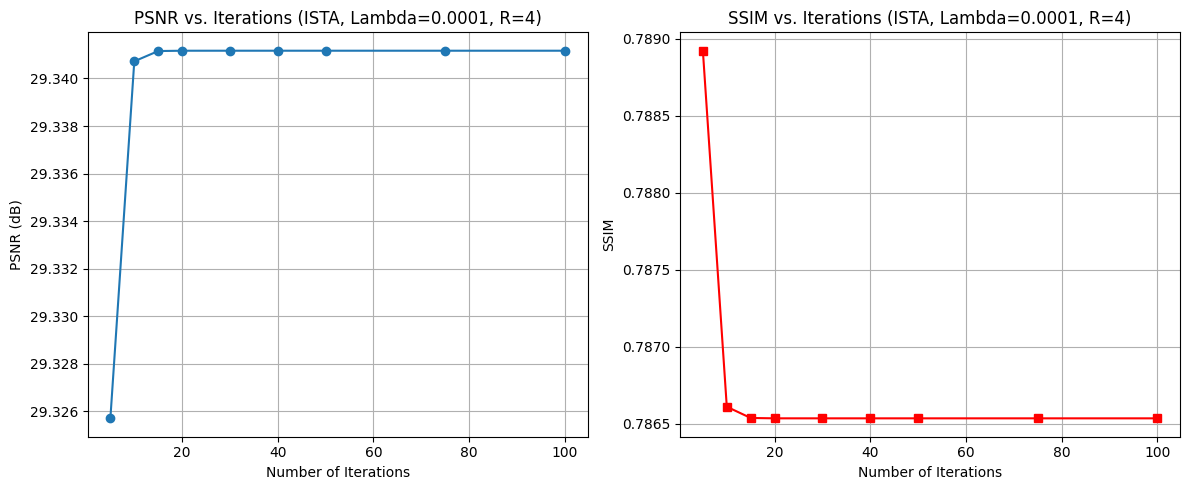

Optimal iterations (heuristic): 10 -> PSNR: 29.34 dB

--- 4. Varying Acceleration Factor ---
  Testing Acceleration Factor R = 2
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 33.5040 dB
ISTA Iteration 2/10, Current PSNR: 34.2845 dB
ISTA Iteration 3/10, Current PSNR: 34.5532 dB
ISTA Iteration 4/10, Current PSNR: 34.6482 dB
ISTA Iteration 5/10, Current PSNR: 34.6849 dB
ISTA Iteration 6/10, Current PSNR: 34.7005 dB
ISTA Iteration 7/10, Current PSNR: 34.7076 dB
ISTA Iteration 8/10, Current PSNR: 34.7110 dB
ISTA Iteration 9/10, Current PSNR: 34.7127 dB
ISTA Iteration 10/10, Current PSNR: 34.7135 dB
  Testing Acceleration Factor R = 3
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 29.0913 dB
ISTA Iteration 2/10, Current PSNR: 29.4880 dB
ISTA Iteration 3/10, Current PSNR: 29.6247 dB
ISTA Iteration 4/10, Current PSNR: 29.6756 dB
ISTA Iteration 5/10, Current PSNR: 29.6965 dB
ISTA Iterati

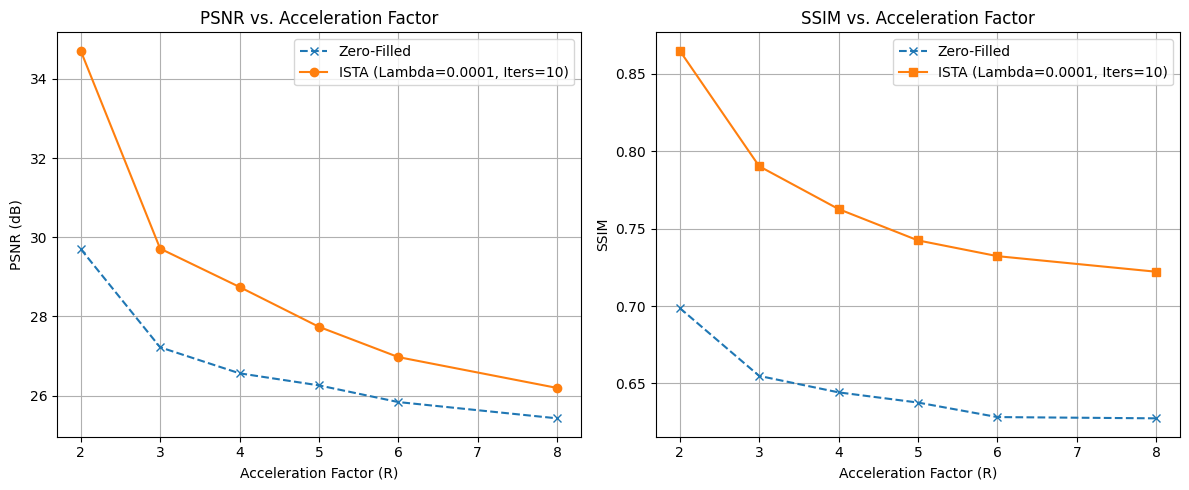


--- 5. Using Different Undersampling Masks ---
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 28.0100 dB
ISTA Iteration 2/10, Current PSNR: 28.3290 dB
ISTA Iteration 3/10, Current PSNR: 28.4448 dB
ISTA Iteration 4/10, Current PSNR: 28.4905 dB
ISTA Iteration 5/10, Current PSNR: 28.5102 dB
ISTA Iteration 6/10, Current PSNR: 28.5192 dB
ISTA Iteration 7/10, Current PSNR: 28.5235 dB
ISTA Iteration 8/10, Current PSNR: 28.5256 dB
ISTA Iteration 9/10, Current PSNR: 28.5266 dB
ISTA Iteration 10/10, Current PSNR: 28.5271 dB
Cartesian Mask (R=4): ZF PSNR=26.51, ISTA PSNR=28.53
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 25.3668 dB
ISTA Iteration 2/10, Current PSNR: 25.7689 dB
ISTA Iteration 3/10, Current PSNR: 25.9207 dB
ISTA Iteration 4/10, Current PSNR: 25.9824 dB
ISTA Iteration 5/10, Current PSNR: 26.0094 dB
ISTA Iteration 6/10, Current PSNR: 26.0219 dB
ISTA Iteration 7/10, Current P

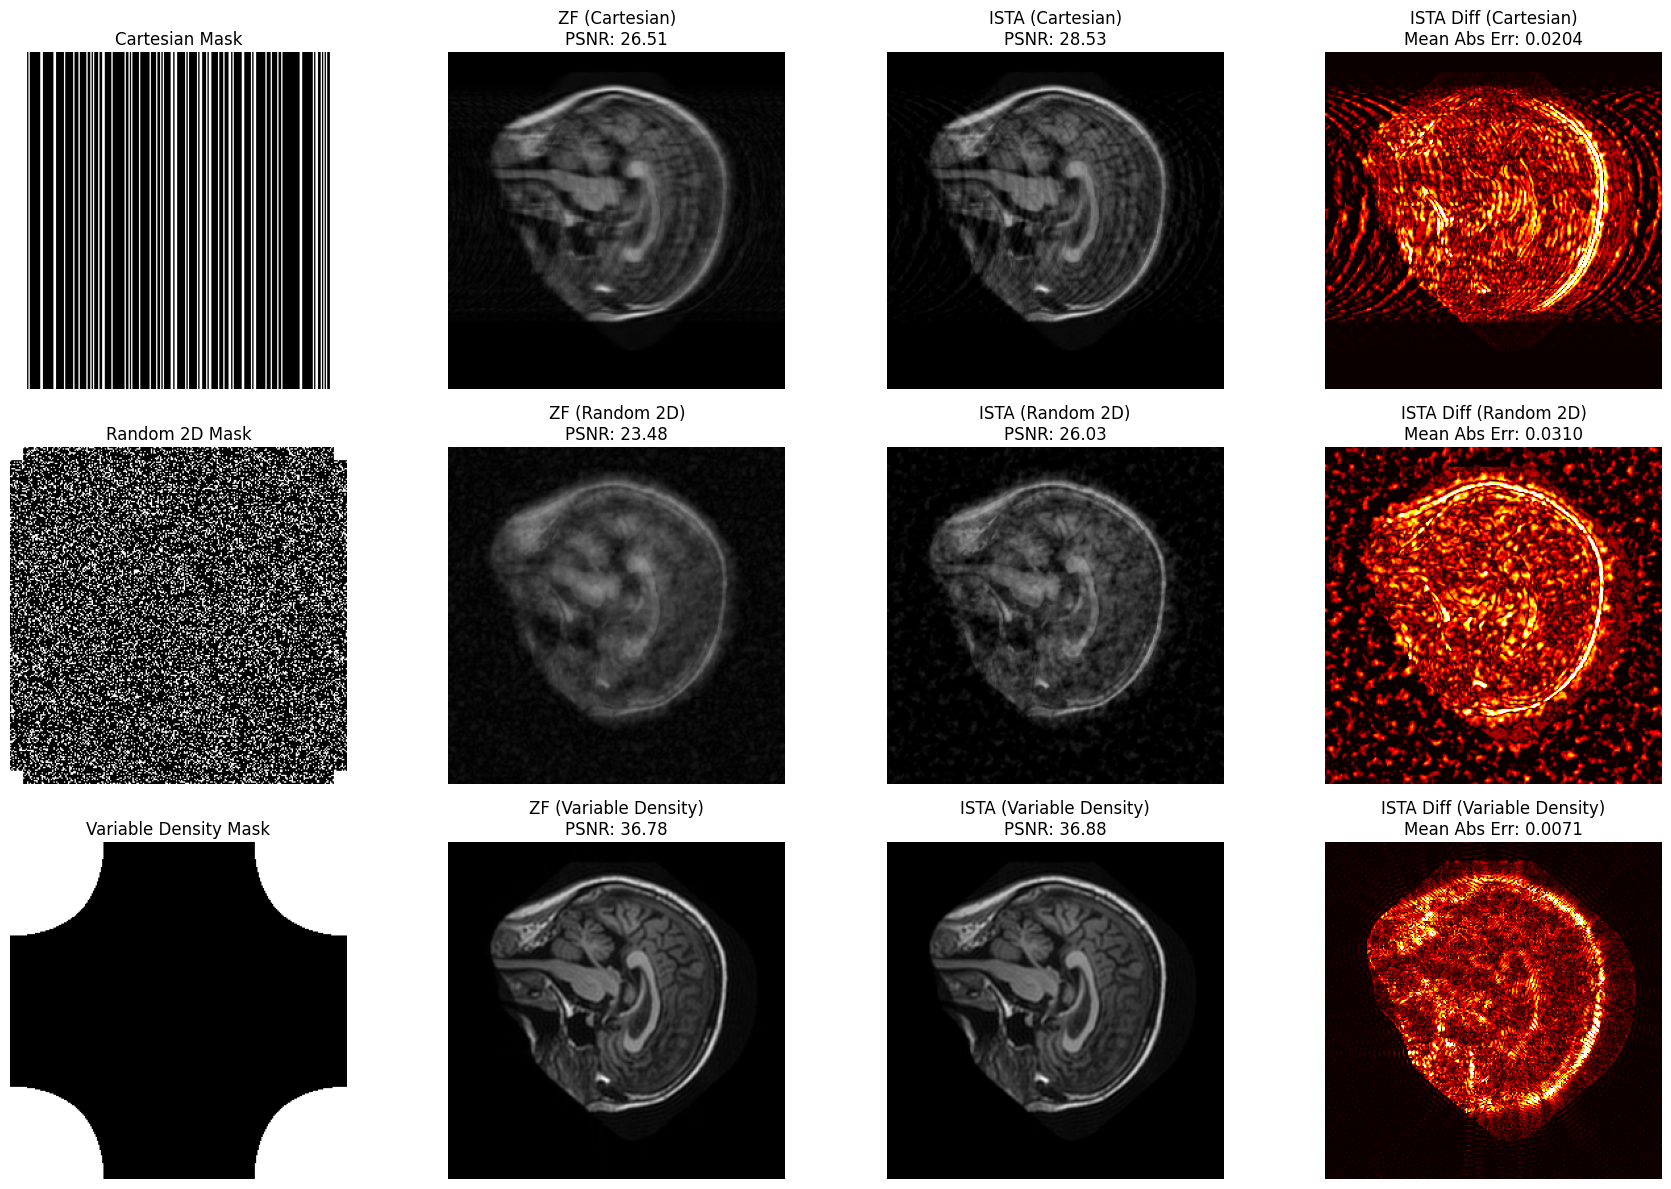


--- Experiments Complete ---


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os # For file path joining if needed later
import time # To time experiments
# --- 1. DEFINE BASE PATHS ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'oasis-1' # This is the name of your dataset folder in /kaggle/input/

# This should be /kaggle/input/oasis-1/
base_dataset_path = os.path.join(base_kaggle_input_path, dataset_name)
print(f"Attempting to use base dataset path: {base_dataset_path}")

if not os.path.isdir(base_dataset_path):
    print(f"ERROR: Base dataset path does not exist: {base_dataset_path}")
    print(f"Listing contents of '{base_kaggle_input_path}': {os.listdir(base_kaggle_input_path)}")
    # If this error occurs, the 'dataset_name' or 'base_kaggle_input_path' is wrong.
    # Or the dataset isn't attached to your Kaggle notebook correctly.
    # Please verify in the Kaggle "Input" section.
    exit() # Stop if the fundamental path is wrong

print(f"Successfully located base dataset path: {base_dataset_path}")
print(f"Contents of '{base_dataset_path}': {os.listdir(base_dataset_path)}")

image_paths = []

# --- 2. FIND CROSS-SECTIONAL DISC PARENT FOLDERS ---
# These are folders like 'oasis_cross-sectional_disc1', 'oasis_cross-sectional_disc10', etc.
# They should be directly under base_dataset_path
disc_parent_folders_names = [
    d for d in os.listdir(base_dataset_path)
    if d.startswith('oasis_cross-sectional_disc') and \
       os.path.isdir(os.path.join(base_dataset_path, d))
]
print(f"\nFound {len(disc_parent_folders_names)} 'oasis_cross-sectional_discX' folders: {disc_parent_folders_names}")

if not disc_parent_folders_names:
    print("ERROR: No 'oasis_cross-sectional_discX' type folders found directly under "
          f"'{base_dataset_path}'. Check your dataset structure.")
    exit()

# --- 3. ITERATE THROUGH EACH DISC PARENT FOLDER ---
for disc_parent_name in disc_parent_folders_names:
    # e.g., disc_parent_name is 'oasis_cross-sectional_disc1'
    # Full path to this folder: /kaggle/input/oasis-1/oasis_cross-sectional_disc1/
    current_disc_parent_path = os.path.join(base_dataset_path, disc_parent_name)
    print(f"\nProcessing Disc Parent Folder: {current_disc_parent_path}")

    # --- 4. FIND THE INNER 'discX' FOLDER ---
    # The actual data is in a subfolder like 'disc1', 'disc2', ... 'disc12'
    # Extract the number part (e.g., '1' from 'oasis_cross-sectional_disc1')
    disc_num_str = disc_parent_name.replace('oasis_cross-sectional_disc', '')
    inner_disc_folder_name = f'disc{disc_num_str}' # e.g., 'disc1', 'disc10'

    # This is the path to the folder that should contain individual subject (OAS1_xxxx_MRy) folders
    # e.g., /kaggle/input/oasis-1/oasis_cross-sectional_disc1/disc1/
    subjects_parent_path = os.path.join(current_disc_parent_path, inner_disc_folder_name)
    print(f"  Looking for subject folders within: {subjects_parent_path}")

    if not os.path.isdir(subjects_parent_path):
        print(f"  WARNING: Expected inner disc folder '{subjects_parent_path}' not found.")
        print(f"  Contents of '{current_disc_parent_path}': {os.listdir(current_disc_parent_path)}")
        print(f"  Skipping '{disc_parent_name}'.")
        continue
    
    print(f"  Found inner disc folder: {subjects_parent_path}")
    # print(f"  Contents of '{subjects_parent_path}': {os.listdir(subjects_parent_path)}")


    # --- 5. FIND SUBJECT FOLDERS (OAS1_xxxx_MRy) ---
    # Glob pattern for subject folders like 'OAS1_0001_MR1', 'OAS1_0002_MR1', etc.
    subject_folder_glob_pattern = os.path.join(subjects_parent_path, 'OAS1_*_MR*')
    subject_folders_found = glob.glob(subject_folder_glob_pattern)
    print(f"  Found {len(subject_folders_found)} subject folders using pattern '{subject_folder_glob_pattern}'.")

    if not subject_folders_found:
        print(f"  WARNING: No subject folders (OAS1_*_MR*) found in '{subjects_parent_path}'.")
        print(f"  Contents of '{subjects_parent_path}' were: {os.listdir(subjects_parent_path)}")
        # continue # Optional: skip to next disc_parent if no subjects found

    for subj_folder_path in subject_folders_found:
        # e.g., subj_folder_path is /kaggle/input/oasis-1/oasis_cross-sectional_disc1/disc1/OAS1_0001_MR1
        # print(f"    Processing Subject Folder: {subj_folder_path}")
        subject_id_from_folder = os.path.basename(subj_folder_path) # e.g., OAS1_0001_MR1

        # --- 6. FIND THE TARGET IMAGE FILE ---
        # Path to the specific image file we want, including the 'MPRAGE' subdirectory
        # Filename structure: OAS1_xxxx_MRy_mpr_ni_anon_sbj_111.img (n_i is num scans, e.g., n4)
        
        # Corrected path including 'MPRAGE'
        image_file_path_pattern = os.path.join(
            subj_folder_path,
            'PROCESSED',
            'MPRAGE',  # This was the missing piece from your detailed example path!
            'SUBJ_111',
            f'{subject_id_from_folder}_mpr_n*_anon_sbj_111.img' # Allows for n1, n2, n3, n4 etc.
        )
        
        # print(f"      Looking for image file with pattern: {image_file_path_pattern}")
        found_img_files = glob.glob(image_file_path_pattern)

        if not found_img_files:
            # Try a more general wildcard if 'n*' didn't match (e.g. if it's just _mpr_1_ or similar)
            image_file_path_pattern_alt = os.path.join(
                subj_folder_path,
                'PROCESSED', 'MPRAGE', 'SUBJ_111',
                f'{subject_id_from_folder}_mpr_*_anon_sbj_111.img'
            )
            # print(f"      Trying alternative pattern: {image_file_path_pattern_alt}")
            found_img_files = glob.glob(image_file_path_pattern_alt)
        
        if found_img_files:
            # Usually, there's one such averaged file. If multiple match, take the first.
            image_paths.append(found_img_files[0])
            # print(f"      SUCCESS: Added image: {found_img_files[0]}")
        else:
            # print(f"      WARNING: No .img file found for {subject_id_from_folder} in PROCESSED/MPRAGE/SUBJ_111.")
            # For detailed debugging, you can list contents of SUBJ_111
            path_to_check = os.path.join(subj_folder_path, 'PROCESSED', 'MPRAGE', 'SUBJ_111')
            if os.path.isdir(path_to_check):
                 pass # print(f"      Contents of '{path_to_check}': {os.listdir(path_to_check)}")
            else:
                 pass # print(f"      Directory '{path_to_check}' does not exist.")


# --- 7. FINAL REPORT ---
print(f"\n--- SUMMARY ---")
print(f"Found {len(image_paths)} potential ground truth images in total.")

if image_paths:
    print(f"First few example paths found:")
    for p in image_paths[:min(5, len(image_paths))]: # Print up to 5 examples
        print(f"  {p}")
else:
    print("No images found. Please carefully review the WARNINGS and ERROR messages above.")
    print("Key things to check:")
    print("  1. Is the `dataset_name` ('oasis-1') correct for your Kaggle input folder?")
    print("  2. Does the structure `oasis-1/oasis_cross-sectional_discX/discX/OAS1_xxxx_MRy/PROCESSED/MPRAGE/SUBJ_111/` match your data?")
    print("  3. Are the file names like `OAS1_xxxx_MRy_mpr_n#_anon_sbj_111.img`?")

# ... (Previous code: Data loading, etc.) ...

# --- 8. LOAD AND DISPLAY A SAMPLE IMAGE (if found) ---
if image_paths:
    print("\n--- Loading a sample image ---")
    # Let's try to load the first image found
    sample_img_path = image_paths[0]
    print(f"Loading: {sample_img_path}")
    try:
        img_obj = nib.load(sample_img_path)
        img_data = img_obj.get_fdata()  # Get data as numpy array
        print(f"  Image shape: {img_data.shape}, Data type: {img_data.dtype}, Min: {np.min(img_data):.2f}, Max: {np.max(img_data):.2f}")

        # --- Selecting a slice ---
        if img_data.ndim == 4 and img_data.shape[3] == 1:  # Handle 4D images
            # For SUBJ_111 images (sagittal): Dim 0 is sagittal slices,  Shape (256, 256, 160, 1).
            # For T88_111 images (transverse/axial): Dim 2 is axial slices.

            # Let's pick an axial-like slice for typical brain viewing, slice from the 3rd dimension (Z)
            central_slice_idx_ax = img_data.shape[2] // 2 # 160//2 = 80
            slice_2d = img_data[:, :, central_slice_idx_ax, 0].astype(np.float32).copy(

            plt.figure(figsize=(8, 8))
            plt.imshow(slice_2d, cmap='gray')  # No rotation for now, display as is
            plt.title(f"Axial-like Slice (Central, Check Orientation)\nfrom {os.path.basename(sample_img_path)}")
            plt.axis('off')
            plt.show()

            ground_truth_image = slice_2d
            # Ensure it's float and normalized for CS processing
            if np.max(ground_truth_image) > np.min(ground_truth_image):
                ground_truth_image = (ground_truth_image - np.min(ground_truth_image)) / \
                                     (np.max(ground_truth_image) - np.min(ground_truth_image))
            else:
                ground_truth_image = np.zeros_like(ground_truth_image)  # Handle constant image

            print(f"\nSelected 2D slice for CS (shape {ground_truth_image.shape}, "
                  f"range [{np.min(ground_truth_image):.2f}, {np.max(ground_truth_image):.2f}])")

        else:
            print(f"  Loaded image data is not 4D (shape: {img_data.shape}). Cannot select slice as expected.")

    except Exception as e:
        print(f"  ERROR loading or processing sample image '{sample_img_path}': {e}")
        import traceback
        traceback.print_exc()

# --- START: Run CS Simulation (k-space, masking, zero-filling) ---
if 'ground_truth_image' in locals(): # Only if a slice was selected
    print("\n--- Starting CS Simulation ---")

    # 1. Transform to k-space
    from numpy.fft import fft2, ifft2, fftshift, ifftshift
    k_space_full = fftshift(fft2(ground_truth_image))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(np.log(1 + np.abs(k_space_full)), cmap='gray')
    plt.title("Log Magnitude of Full k-space")
    plt.subplot(1,2,2)
    plt.imshow(np.angle(k_space_full), cmap='gray')
    plt.title("Phase of Full k-space")
    plt.show()

    # 2. Design Undersampling Mask (Cartesian as example)
    def create_cartesian_mask(shape, acceleration_factor, center_fraction=0.1):
        num_cols = shape[1]
        num_low_freqs = int(round(num_cols * center_fraction))
        mask = np.zeros(shape, dtype=bool)
        # Center region (fully sampled)
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[:, pad:pad + num_low_freqs] = True
        # Outer region (undersampled)
        num_sampled_lines_outer = (num_cols - num_low_freqs) // acceleration_factor
        outer_lines_indices = np.setdiff1d(np.arange(num_cols), np.arange(pad, pad + num_low_freqs))
        permuted_outer_lines = np.random.permutation(outer_lines_indices)
        selected_outer_lines = permuted_outer_lines[:num_sampled_lines_outer]
        mask[:, selected_outer_lines] = True
        return mask

    acceleration = 4  # Undersample by a factor of 4
    mask = create_cartesian_mask(k_space_full.shape, acceleration)

    plt.imshow(mask, cmap='gray')
    plt.title(f"1D Cartesian Mask (R={acceleration})")
    plt.show()

    # 3. Apply Mask
    k_space_undersampled = k_space_full * mask

    # 4. Zero-filled Reconstruction (Baseline)
    image_undersampled_recon = np.abs(ifft2(ifftshift(k_space_undersampled)))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ground_truth_image, cmap='gray') # Show original slice
    plt.title("Ground Truth")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image_undersampled_recon, cmap='gray') # Show reconstructed image
    plt.title(f"Zero-filled Recon (R={acceleration})")
    plt.axis('off')
    plt.show()

    # 5. Quantitative Evaluation (PSNR, SSIM)
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim

    psnr_val_zf = psnr(ground_truth_image, image_undersampled_recon, data_range=ground_truth_image.max() - ground_truth_image.min())
    ssim_val_zf = ssim(ground_truth_image, image_undersampled_recon, data_range=ground_truth_image.max() - ground_truth_image.min())
    print(f"Zero-Filled: PSNR={psnr_val_zf:.2f} dB, SSIM={ssim_val_zf:.4f}")

    # The following lines are needed to start the reconstruction process
    # Add the Compressed Sensing Reconstruction Here (e.g. using ISTA/FISTA/ADMM)
    # cs_reconstructed_image = YourCSReconstructionFunction(k_space_undersampled, mask, ground_truth_image.shape)

    # Then measure these, and then make sure to make a separate plot.
    # psnr_val_cs = psnr(ground_truth_image, cs_reconstructed_image, data_range=...)
    # ssim_val_cs = ssim(ground_truth_image, cs_reconstructed_image, data_range=...)
    # print(f"CS Recon: PSNR={psnr_val_cs:.2f} dB, SSIM={ssim_val_cs:.4f}")
else:
    print("No slice selected - skipping CS simulation.")


# Example placeholder for what you should have from previous steps:
# This is just for this script to be runnable standalone for demonstration.
# In your notebook, these variables will be populated by your data loading and zero-filled recon steps.
if 'ground_truth_image' not in locals():
    print("INFO: 'ground_truth_image' not found. Creating a dummy one for demonstration.")
    # Create a dummy ground truth image (e.g., Shepp-Logan phantom)
    from skimage.data import shepp_logan_phantom
    from skimage.transform import resize
    phantom = shepp_logan_phantom()
    ground_truth_image = resize(phantom, (256, 256), anti_aliasing=True)
    if np.max(ground_truth_image) > np.min(ground_truth_image): # Normalize
        ground_truth_image = (ground_truth_image - np.min(ground_truth_image)) / \
                             (np.max(ground_truth_image) - np.min(ground_truth_image))
    else:
        ground_truth_image = np.zeros_like(ground_truth_image)

    # Dummy k-space and zero-filled recon
    k_space_full = fftshift(fft2(ground_truth_image))
    
    def create_cartesian_mask(shape, acceleration_factor, center_fraction=0.08):
        num_cols = shape[1]
        num_low_freqs = int(round(num_cols * center_fraction))
        mask = np.zeros(shape, dtype=bool)
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[:, pad:pad + num_low_freqs] = True
        num_sampled_lines_outer = (num_cols - num_low_freqs) // acceleration_factor
        outer_lines_indices = np.setdiff1d(np.arange(num_cols), np.arange(pad, pad + num_low_freqs))
        permuted_outer_lines = np.random.permutation(outer_lines_indices)
        selected_outer_lines = permuted_outer_lines[:num_sampled_lines_outer]
        mask[:, selected_outer_lines] = True
        return mask

    acceleration_default = 4
    mask_default = create_cartesian_mask(k_space_full.shape, acceleration_default)
    k_space_undersampled_default = k_space_full * mask_default
    image_undersampled_recon_default = np.abs(ifft2(ifftshift(k_space_undersampled_default)))
    
    # Use these defaults if the real ones aren't loaded
    if 'k_space_undersampled' not in locals(): k_space_undersampled = k_space_undersampled_default
    if 'mask' not in locals(): mask = mask_default
    if 'image_undersampled_recon' not in locals(): image_undersampled_recon = image_undersampled_recon_default
    if 'acceleration' not in locals(): acceleration = acceleration_default

    if 'psnr_val_zf' not in locals():
        psnr_val_zf = psnr(ground_truth_image, image_undersampled_recon, data_range=1.0)
        ssim_val_zf = ssim(ground_truth_image, image_undersampled_recon, data_range=1.0, channel_axis=None)
        print(f"Dummy Zero-Filled: PSNR={psnr_val_zf:.2f} dB, SSIM={ssim_val_zf:.4f}")

def soft_threshold(x, threshold):
    """Soft-thresholding operator."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

# For Wavelet Transform (requires PyWavelets: pip install PyWavelets)
import pywt

def wavelet_forward(image, wavelet='db4', level=3):
    """Apply forward wavelet transform."""
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr, coeff_slices

def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
    """Apply inverse wavelet transform."""
    coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                    ground_truth_for_psnr, # Pass ground truth for monitoring
                    wavelet='db4', level=3):
    """
    ISTA for CS MRI reconstruction with wavelet sparsity.
    (Corrected handling of wavelet coefficients)
    """
    x_recon = initial_image.copy().astype(np.complex128) # Work with complex numbers internally
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    
    step_size = 1.0 # Lipschitz constant, often 1 for normalized Fourier data

    print(f"Starting ISTA: iterations={n_iters}, lambda={lambda_val}, wavelet={wavelet}, level={level}")

    for i in range(n_iters):
        # 1. Gradient descent step (data consistency)
        current_k_space = fftshift(fft2(x_recon))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        # The gradient involves A*(Ax-y), where A is F_u and A* is F_u_adj
        # A*(k_err) = F_inv(mask * k_err)
        grad_data_term = ifft2(ifftshift(k_space_error * mask)) # Mask applied due to A*
        
        x_intermediate = x_recon - step_size * grad_data_term # grad_data_term is already complex

        # 2. Proximal operator for L1 norm in wavelet domain (soft-thresholding)
        # Apply wavelet transform (to the real part, assuming image is real-valued)
        # If your image is truly complex, wavelet transform needs to handle complex data
        # For MRI magnitude images, we usually work with the real part for wavelet transform.
        x_intermediate_real = np.real(x_intermediate)
        
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        
        threshold = lambda_val * step_size
        
        # is given by the shape described in coeff_slices[0]
        approx_coeffs_slice_info = coeff_slices[0] # This is just a slice object for the cA coeffs
        
        # Alternative way to get the size of the approx coeffs:
        # The first set of coefficients from pywt.wavedec2 is cA_n (approximation at level n)
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size # Number of elements in cA_n

        coeffs_arr_thresh = coeffs_arr.copy()
        # Do NOT threshold the approximation coefficients (the first `approx_coeffs_size` elements)
        # Threshold only the detail coefficients (everything after the approx_coeffs)
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        
        # Inverse wavelet transform
        x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
        
        # Combine with imaginary part if you were preserving it (often not done for mag images)
        x_recon = x_reconstructed_real.astype(np.complex128) # Assume result is real after wavelet step

        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            # For PSNR, compare with the real part, clipped and normalized if ground truth is.
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"ISTA Iteration {i+1}/{n_iters}, Current PSNR: {current_psnr:.4f} dB")
            
    return np.clip(np.real(x_recon), 0, 1) # Return real part, clipped

# Check if ista_wavelet_cs is defined, if not, define a placeholder
if 'ista_wavelet_cs' not in locals():
    print("WARNING: 'ista_wavelet_cs' not defined. Using a placeholder that returns initial image.")
    def ista_wavelet_cs(k_space_undersampled_local, mask_local, initial_image_local, n_iters, lambda_val,
                        ground_truth_for_psnr, wavelet='db4', level=3):
        print(f"Placeholder ISTA called: iters={n_iters}, lambda={lambda_val}. Returning initial image.")
        final_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(initial_image_local),0,1), data_range=1.0)
        print(f"ISTA Iteration {n_iters}/{n_iters}, Current PSNR: {final_psnr:.4f} dB (placeholder)")
        return np.clip(np.real(initial_image_local), 0, 1)


# --- 1. Visualize the Results (assuming you have one CS reconstruction done) ---
# Let's assume you have 'cs_reconstructed_image_ista' from your previous run
# If not, run a default one here:
if 'cs_reconstructed_image_ista' not in locals():
    print("INFO: 'cs_reconstructed_image_ista' not found. Running a default ISTA.")
    default_lambda = 0.005
    default_iters = 10 # Keep it short for this demo
    cs_reconstructed_image_ista = ista_wavelet_cs(
        k_space_undersampled, mask, image_undersampled_recon.copy(),
        n_iters=default_iters, lambda_val=default_lambda,
        ground_truth_for_psnr=ground_truth_image
    )
    psnr_val_ista_default = psnr(ground_truth_image, cs_reconstructed_image_ista, data_range=1.0)
    ssim_val_ista_default = ssim(ground_truth_image, cs_reconstructed_image_ista, data_range=1.0, channel_axis=None)
    print(f"Default ISTA: PSNR={psnr_val_ista_default:.2f} dB, SSIM={ssim_val_ista_default:.4f} (lambda={default_lambda})")


print("\n--- 1. Visualizing Current Results ---")
if 'cs_reconstructed_image_ista' in locals():
    psnr_val_current_ista = psnr(ground_truth_image, cs_reconstructed_image_ista, data_range=1.0)
    ssim_val_current_ista = ssim(ground_truth_image, cs_reconstructed_image_ista, data_range=1.0, channel_axis=None)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(ground_truth_image, cmap='gray', vmin=0, vmax=1)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(image_undersampled_recon, cmap='gray', vmin=0, vmax=1)
    plt.title(f"Zero-filled (R={acceleration})\nPSNR: {psnr_val_zf:.2f} dB\nSSIM: {ssim_val_zf:.4f}")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(cs_reconstructed_image_ista, cmap='gray', vmin=0, vmax=1)
    plt.title(f"ISTA Wavelet (R={acceleration})\nPSNR: {psnr_val_current_ista:.2f} dB\nSSIM: {ssim_val_current_ista:.4f}")
    plt.axis('off')

    # Difference Image
    diff_ista = np.abs(ground_truth_image - cs_reconstructed_image_ista)
    plt.subplot(1, 4, 4)
    plt.imshow(diff_ista, cmap='hot', vmin=0, vmax=np.percentile(diff_ista,99)) # Scale colormap
    plt.title(f"Difference (GT - ISTA)\nMean Abs Error: {np.mean(diff_ista):.4f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization as 'cs_reconstructed_image_ista' is not available.")


# --- 2. Tune lambda_ista Further ---
print("\n--- 2. Tuning Lambda for ISTA ---")
lambda_values_to_test = [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05]
iters_for_lambda_tuning = 30 # Fixed number of iterations for this tuning
psnr_results_lambda = []
ssim_results_lambda = []

for lam_val in lambda_values_to_test:
    print(f"  Testing Lambda: {lam_val}")
    temp_recon = ista_wavelet_cs(
        k_space_undersampled, mask, image_undersampled_recon.copy(),
        n_iters=iters_for_lambda_tuning, lambda_val=lam_val,
        ground_truth_for_psnr=ground_truth_image
    )
    psnr_results_lambda.append(psnr(ground_truth_image, temp_recon, data_range=1.0))
    ssim_results_lambda.append(ssim(ground_truth_image, temp_recon, data_range=1.0, channel_axis=None))

# Plotting Lambda Tuning Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lambda_values_to_test, psnr_results_lambda, marker='o')
plt.xscale('log') # Lambdas often vary over orders of magnitude
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("PSNR (dB)")
plt.title(f"PSNR vs. Lambda (ISTA, {iters_for_lambda_tuning} iterations, R={acceleration})")
plt.grid(True, which="both", ls="-")

plt.subplot(1, 2, 2)
plt.plot(lambda_values_to_test, ssim_results_lambda, marker='s', color='r')
plt.xscale('log')
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("SSIM")
plt.title(f"SSIM vs. Lambda (ISTA, {iters_for_lambda_tuning} iterations, R={acceleration})")
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.show()

# Find and print the best lambda
if psnr_results_lambda:
    best_lambda_idx_psnr = np.argmax(psnr_results_lambda)
    best_lambda_psnr = lambda_values_to_test[best_lambda_idx_psnr]
    print(f"Best Lambda (for PSNR): {best_lambda_psnr} -> PSNR: {psnr_results_lambda[best_lambda_idx_psnr]:.2f} dB")

    best_lambda_idx_ssim = np.argmax(ssim_results_lambda)
    best_lambda_ssim = lambda_values_to_test[best_lambda_idx_ssim]
    print(f"Best Lambda (for SSIM): {best_lambda_ssim} -> SSIM: {ssim_results_lambda[best_lambda_idx_ssim]:.4f}")
    optimal_lambda = best_lambda_psnr # Choose one, e.g., based on PSNR for further tests
else:
    optimal_lambda = 0.005 # Fallback if tuning didn't run
    print("Lambda tuning did not produce results. Using default optimal_lambda.")


# --- 3. Experiment with num_iterations_ista ---
print("\n--- 3. Experimenting with Number of Iterations ---")
# Use the 'optimal_lambda' found above, or a good default
lambda_for_iter_test = optimal_lambda
iterations_to_test = [5, 10, 15, 20, 30, 40, 50, 75, 100]
psnr_results_iters = []
ssim_results_iters = []

for num_iters in iterations_to_test:
    print(f"  Testing Iterations: {num_iters} (Lambda: {lambda_for_iter_test})")
    temp_recon = ista_wavelet_cs(
        k_space_undersampled, mask, image_undersampled_recon.copy(),
        n_iters=num_iters, lambda_val=lambda_for_iter_test,
        ground_truth_for_psnr=ground_truth_image
    )
    psnr_results_iters.append(psnr(ground_truth_image, temp_recon, data_range=1.0))
    ssim_results_iters.append(ssim(ground_truth_image, temp_recon, data_range=1.0, channel_axis=None))

# Plotting Iteration Tuning Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(iterations_to_test, psnr_results_iters, marker='o')
plt.xlabel("Number of Iterations")
plt.ylabel("PSNR (dB)")
plt.title(f"PSNR vs. Iterations (ISTA, Lambda={lambda_for_iter_test:.4f}, R={acceleration})")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iterations_to_test, ssim_results_iters, marker='s', color='r')
plt.xlabel("Number of Iterations")
plt.ylabel("SSIM")
plt.title(f"SSIM vs. Iterations (ISTA, Lambda={lambda_for_iter_test:.4f}, R={acceleration})")
plt.grid(True)
plt.tight_layout()
plt.show()

optimal_iters = 50 # Choose based on plots, e.g., where it plateaus.
if psnr_results_iters:
    # Heuristic: find where PSNR is within 0.01 dB of max and take the earliest
    max_psnr_iter = np.max(psnr_results_iters)
    try:
        optimal_iters_idx = np.where(np.array(psnr_results_iters) >= max_psnr_iter - 0.01)[0][0]
        optimal_iters = iterations_to_test[optimal_iters_idx]
        print(f"Optimal iterations (heuristic): {optimal_iters} -> PSNR: {psnr_results_iters[optimal_iters_idx]:.2f} dB")
    except IndexError:
        print("Could not determine optimal_iters heuristically, using default 50.")
        optimal_iters = 50
else:
    print("Iteration tuning did not produce results. Using default optimal_iters.")


# --- 4. Vary Acceleration Factor (acceleration) ---
print("\n--- 4. Varying Acceleration Factor ---")
acceleration_factors_to_test = [2, 3, 4, 5, 6, 8]
# Use optimal_lambda and optimal_iters found from previous steps, or good defaults
lambda_for_accel_test = optimal_lambda
iters_for_accel_test = optimal_iters

psnr_zf_accel = []
ssim_zf_accel = []
psnr_ista_accel = []
ssim_ista_accel = []

for accel_R in acceleration_factors_to_test:
    print(f"  Testing Acceleration Factor R = {accel_R}")
    # Create new mask and undersampled k-space for this R
    current_mask = create_cartesian_mask(k_space_full.shape, accel_R)
    current_k_space_undersampled = k_space_full * current_mask
    current_image_zf = np.abs(ifft2(ifftshift(current_k_space_undersampled)))

    psnr_zf_accel.append(psnr(ground_truth_image, current_image_zf, data_range=1.0))
    ssim_zf_accel.append(ssim(ground_truth_image, current_image_zf, data_range=1.0, channel_axis=None))

    ista_recon_accel = ista_wavelet_cs(
        current_k_space_undersampled, current_mask, current_image_zf.copy(),
        n_iters=iters_for_accel_test, lambda_val=lambda_for_accel_test, # Note: optimal lambda might change with R!
        ground_truth_for_psnr=ground_truth_image
    )
    psnr_ista_accel.append(psnr(ground_truth_image, ista_recon_accel, data_range=1.0))
    ssim_ista_accel.append(ssim(ground_truth_image, ista_recon_accel, data_range=1.0, channel_axis=None))

# Plotting Acceleration Factor Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acceleration_factors_to_test, psnr_zf_accel, marker='x', linestyle='--', label='Zero-Filled')
plt.plot(acceleration_factors_to_test, psnr_ista_accel, marker='o', label=f'ISTA (Lambda={lambda_for_accel_test:.4f}, Iters={iters_for_accel_test})')
plt.xlabel("Acceleration Factor (R)")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Acceleration Factor")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(acceleration_factors_to_test, ssim_zf_accel, marker='x', linestyle='--', label='Zero-Filled')
plt.plot(acceleration_factors_to_test, ssim_ista_accel, marker='s', label=f'ISTA (Lambda={lambda_for_accel_test:.4f}, Iters={iters_for_accel_test})')
plt.xlabel("Acceleration Factor (R)")
plt.ylabel("SSIM")
plt.title("SSIM vs. Acceleration Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- 5. Use Different Undersampling Masks ---
print("\n--- 5. Using Different Undersampling Masks ---")
# (Keep acceleration, lambda, iters fixed for this comparison, e.g., R=4)
fixed_R_for_mask_test = 4
fixed_lambda_for_mask_test = optimal_lambda
fixed_iters_for_mask_test = optimal_iters

# a) Cartesian Mask (already have this)
mask_cartesian = create_cartesian_mask(k_space_full.shape, fixed_R_for_mask_test)
k_space_cartesian = k_space_full * mask_cartesian
zf_cartesian = np.abs(ifft2(ifftshift(k_space_cartesian)))
psnr_zf_cartesian = psnr(ground_truth_image, zf_cartesian, data_range=1.0)
ista_cartesian = ista_wavelet_cs(k_space_cartesian, mask_cartesian, zf_cartesian.copy(),
                                 fixed_iters_for_mask_test, fixed_lambda_for_mask_test, ground_truth_image)
psnr_ista_cartesian = psnr(ground_truth_image, ista_cartesian, data_range=1.0)
print(f"Cartesian Mask (R={fixed_R_for_mask_test}): ZF PSNR={psnr_zf_cartesian:.2f}, ISTA PSNR={psnr_ista_cartesian:.2f}")


# b) Random 2D Mask (ensure k-space center is sampled for stability)
def create_random_2d_mask(shape, acceleration_factor, center_fraction=0.08, seed=None):
    if seed is not None:
        np.random.seed(seed)
    num_points = int(np.prod(shape) / acceleration_factor)
    mask = np.zeros(shape, dtype=bool)
    
    # Fully sample center
    center_rows = int(shape[0] * center_fraction)
    center_cols = int(shape[1] * center_fraction)
    r_start, r_end = shape[0]//2 - center_rows//2, shape[0]//2 + center_rows//2
    c_start, c_end = shape[1]//2 - center_cols//2, shape[1]//2 + center_cols//2
    mask[r_start:r_end, c_start:c_end] = True
    
    num_sampled_center = np.sum(mask)
    remaining_points_to_sample = num_points - num_sampled_center

    if remaining_points_to_sample > 0:
        # Create a flat list of indices for points outside the center
        outer_indices = []
        for r in range(shape[0]):
            for c in range(shape[1]):
                if not (r_start <= r < r_end and c_start <= c < c_end):
                    outer_indices.append((r, c))
        
        if len(outer_indices) > 0:
            chosen_outer_indices_flat = np.random.choice(len(outer_indices), 
                                                     min(remaining_points_to_sample, len(outer_indices)), 
                                                     replace=False)
            for flat_idx in chosen_outer_indices_flat:
                r, c = outer_indices[flat_idx]
                mask[r, c] = True
    return mask

mask_random2d = create_random_2d_mask(k_space_full.shape, fixed_R_for_mask_test, seed=0) # Seed for reproducibility
k_space_random2d = k_space_full * mask_random2d
zf_random2d = np.abs(ifft2(ifftshift(k_space_random2d)))
psnr_zf_random2d = psnr(ground_truth_image, zf_random2d, data_range=1.0)
ista_random2d = ista_wavelet_cs(k_space_random2d, mask_random2d, zf_random2d.copy(),
                                fixed_iters_for_mask_test, fixed_lambda_for_mask_test, ground_truth_image)
psnr_ista_random2d = psnr(ground_truth_image, ista_random2d, data_range=1.0)
print(f"Random 2D Mask (R={fixed_R_for_mask_test}): ZF PSNR={psnr_zf_random2d:.2f}, ISTA PSNR={psnr_ista_random2d:.2f}")

# c) Variable Density Random Mask (Polynomial, e.g., p=2 for quadratic decay)
def create_variable_density_mask(shape, acceleration_factor, center_fraction=0.08, poly_degree=2, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # Create probability density function (PDF)
    rows, cols = shape
    center_x, center_y = cols // 2, rows // 2
    x_coords = np.abs(np.arange(cols) - center_x)
    y_coords = np.abs(np.arange(rows) - center_y)
    dist_x, dist_y = np.meshgrid(x_coords, y_coords)
    
    # Normalize distances to [-1, 1] like range, though 0 to max_dist is fine
    norm_dist_x = dist_x / (np.max(dist_x) if np.max(dist_x) > 0 else 1)
    norm_dist_y = dist_y / (np.max(dist_y) if np.max(dist_y) > 0 else 1)
    
    # Simple polynomial PDF (1 - r^p), higher probability at center
    pdf = (1 - norm_dist_x**poly_degree) * (1 - norm_dist_y**poly_degree)
    pdf = np.clip(pdf, 0, 1) # Ensure probabilities are valid

    # Scale PDF to achieve desired acceleration
    target_samples = int(np.prod(shape) / acceleration_factor)
    
    # Iteratively adjust scaling of PDF until close to target_samples
    # This is a bit heuristic; a more robust way involves sorting and picking top N based on PDF values
    # For simplicity here, we'll threshold a scaled PDF
    
    # Simple thresholding approach:
    # Sort PDF values and pick top N. This is more robust than scaling.
    flat_pdf = pdf.flatten()
    sorted_indices = np.argsort(-flat_pdf) # Sort descending
    
    mask = np.zeros(shape, dtype=bool).flatten()
    mask[sorted_indices[:target_samples]] = True
    mask = mask.reshape(shape)

    # Ensure center is fully sampled (override if necessary)
    center_rows_abs = int(shape[0] * center_fraction)
    center_cols_abs = int(shape[1] * center_fraction)
    r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
    c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
    mask[r_start:r_end, c_start:c_end] = True
    
    actual_accel = np.prod(shape) / np.sum(mask)
    print(f"  Variable Density Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
    return mask

mask_vd_random = create_variable_density_mask(k_space_full.shape, fixed_R_for_mask_test, poly_degree=2, seed=0)
k_space_vd_random = k_space_full * mask_vd_random
zf_vd_random = np.abs(ifft2(ifftshift(k_space_vd_random)))
psnr_zf_vd_random = psnr(ground_truth_image, zf_vd_random, data_range=1.0)
ista_vd_random = ista_wavelet_cs(k_space_vd_random, mask_vd_random, zf_vd_random.copy(),
                                 fixed_iters_for_mask_test, fixed_lambda_for_mask_test, ground_truth_image)
psnr_ista_vd_random = psnr(ground_truth_image, ista_vd_random, data_range=1.0)
print(f"Variable Density Mask (R={fixed_R_for_mask_test}): ZF PSNR={psnr_zf_vd_random:.2f}, ISTA PSNR={psnr_ista_vd_random:.2f}")


# Displaying Mask Results
plt.figure(figsize=(18, 12))
masks_to_show = [
    (mask_cartesian, "Cartesian", zf_cartesian, ista_cartesian, psnr_zf_cartesian, psnr_ista_cartesian),
    (mask_random2d, "Random 2D", zf_random2d, ista_random2d, psnr_zf_random2d, psnr_ista_random2d),
    (mask_vd_random, "Variable Density", zf_vd_random, ista_vd_random, psnr_zf_vd_random, psnr_ista_vd_random)
]

for i, (m, title, zf_img, ista_img, p_zf, p_ista) in enumerate(masks_to_show):
    plt.subplot(3, 4, i*4 + 1)
    plt.imshow(fftshift(m), cmap='gray') # fftshift for display
    plt.title(f"{title} Mask")
    plt.axis('off')

    plt.subplot(3, 4, i*4 + 2)
    plt.imshow(zf_img, cmap='gray', vmin=0, vmax=1)
    plt.title(f"ZF ({title})\nPSNR: {p_zf:.2f}")
    plt.axis('off')
    
    plt.subplot(3, 4, i*4 + 3)
    plt.imshow(ista_img, cmap='gray', vmin=0, vmax=1)
    plt.title(f"ISTA ({title})\nPSNR: {p_ista:.2f}")
    plt.axis('off')

    diff_img_mask = np.abs(ground_truth_image - ista_img)
    plt.subplot(3, 4, i*4 + 4)
    plt.imshow(diff_img_mask, cmap='hot', vmin=0, vmax=np.percentile(diff_img_mask, 99))
    plt.title(f"ISTA Diff ({title})\nMean Abs Err: {np.mean(diff_img_mask):.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Experiments Complete ---")